In [1]:
import math
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib as mpl
import paste
import scanpy as sc
import anndata
from sklearn.decomposition import NMF
import scanorama
import scipy

style.use('seaborn-dark')
mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14) 

In [2]:
def rotate_spots(grid,spots,theta=0,translation=0,center_correction=0,figsize=(5,5),plot=True):
    grid = grid.copy() + center_correction
    spots = spots.copy() + center_correction
    R = np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])
    rotated_spots = np.array([R.dot(spots[i]) for i in range(len(spots))])
    rotated_spots += translation

    new_spots = grid[np.argmin(scipy.spatial.distance.cdist(rotated_spots,grid),axis=1)]

    grid -= center_correction
    spots -= center_correction
    rotated_spots -= center_correction
    new_spots -= center_correction

    seen = {}
    mapping = []
    for i in range(len(new_spots)):
        if tuple(new_spots[i]) in seen: continue
        seen[tuple(new_spots[i])] = 1
        mapping.append(i)

    if plot:
        fig = plt.figure(figsize=figsize)
        sns.scatterplot(x = grid[:,0],y = grid[:,1],linewidth=0,s=100, marker=".",alpha=0.2,color='blue')
        sns.scatterplot(x = rotated_spots[:,0],y = rotated_spots[:,1],linewidth=0,s=100, marker=".",color='red')
        sns.scatterplot(x = new_spots[:,0],y = new_spots[:,1],linewidth=0,s=100, marker=".",color='green')
        plt.show()

    return new_spots,mapping

In [3]:
def load_breast_layer(path):
    X = pd.read_csv(path, delimiter = '\t', index_col= 0)
    coor = []
    for c in X.index:
        
        coor.append([float(x) for x in c.split('x')])
    adata = anndata.AnnData(X = X)
    adata.obsm['spatial'] = np.array(coor)
    return adata

In [4]:
layer1_path = "../breast_cancer_data/Layer1_BC_count_matrix-1.tsv"
layer2_path = "../breast_cancer_data/Layer2_BC_count_matrix-1.tsv"
layer3_path = "../breast_cancer_data/Layer3_BC_count_matrix-1.tsv"
layer4_path = "../breast_cancer_data/Layer4_BC_count_matrix-1.tsv"
adata_layer_1 = load_breast_layer(layer1_path)
adata_layer_2 = load_breast_layer(layer2_path)
adata_layer_3 = load_breast_layer(layer3_path)
adata_layer_4 = load_breast_layer(layer4_path)

# Define Simulation Functions

We skip the description as they are the same as in the Pairwise Simulation and Center Simulation notebooks.

In [5]:
def simulate_spatial(adata, rotation_angle):
    adata_sim = adata.copy()
    grid_size = 40
    layer_grid = np.array([[x,y] for x in range(grid_size) for y in range(grid_size)])
    new_spots, mappings = rotate_spots(layer_grid, adata.obsm['spatial'], center_correction=-15, theta= rotation_angle)
    adata_sim.obsm['spatial'] = new_spots
    return adata_sim[mappings, :], mappings

def simulate_gene_exp(adata, pc = 0.25, factor = 1):
    """
    Adds noise to gene expression data. The rows are simulated according to a Multinomial distribution, 
    with the total counts per spot drawn from a Negative Binomial Distribution.
    param: pc- Pseudocount to be added to dataframe
    param: factor - amount by which we scale the variance (to increase noise)
    """
    adata_sim = adata.copy()
    df = pd.DataFrame(adata_sim.X)
    # add pseudocounts 
    alpha = df.copy().to_numpy() + pc

    # get vector of total counts per spot
    n = df.sum(axis=1).to_numpy()

    # Simulate total counts using negative binomial
    mean = np.mean(n)
    var = np.var(n)*factor
    n = sample_nb(mean, var, len(n)).astype(int)

    # Reassign zero counts so we don't divide by 0 in future calcuation
    n[n == 0] = 1

    # convert to float
    alpha = np.array(alpha, dtype=np.float64)
    n = np.array(n, dtype=np.float64)

    # convert rows to unit vectors
    alpha = alpha/alpha.sum(axis=1)[:, None]

    dist = np.empty(df.shape)
    for i in range(alpha.shape[0]):
        dist[i] = np.random.multinomial(n[i], alpha[i])
    new_df = pd.DataFrame(dist, index= df.index, columns= df.columns)
    adata_sim.X = new_df
    return adata_sim

def sample_nb(m, v, n = 1):
    """
    param: m - mean
    param: v - variance
    param: n - number of samples
    return: random sample from negative binomial distribution
    """
    r = m**2/(v - m)
    p = m/v
    samples = np.random.negative_binomial(r, p, n)
    return samples

# Define Simulation

First, our metric is the total KL divergence between mapped spots. In our simulation, we have it set up such that the ith spot in layer A maps to the ith spot in layer B, so our calculation is sum of KL divergence between all ith rows in gene expression matrices X and Y.

In [6]:
from scipy.stats import entropy

# Ignores 0s
def kl_divergence(X, Y):
    assert X.shape == Y.shape, "X and Y have different dimensions."
    X = X/X.sum(axis=1, keepdims=True)
    Y = Y/Y.sum(axis=1, keepdims=True)
    s = 0

    c = np.true_divide(X,Y)
    c = np.log(c)
    c = np.nan_to_num(c, neginf=0, posinf = 0)

    return np.sum(np.multiply(X, c))

# alternate kl divergence that adds pseudocount to avoid dividing by 0
def kl_divergence2 (X, Y):
    assert X.shape == Y.shape, "X and Y have different dimensions."
    X += 0.01
    Y += 0.01
    s = 0
    for i in range(X.shape[0]):
        e = entropy(X[i], Y[i])
        if not np.isinf(e):
            s += e 
    return s

Next, given a layer, we simulate three layers. Then, we infer a center layer using PASTE. For Scanorama, we integrated all three layers. Finally we calculate the KL divergence between the original layer and the inferred layer. For Scanorama, we calculate the KL divergence between the original layer and each of the integrated layers and take the average of the three.

In [7]:
def scanorama_sim(base_layer, sim_layers, maps):
    b = base_layer.copy()
    corrected = scanorama.correct_scanpy(sim_layers)
    
    genes = corrected[0].var_names
    b = b[:, genes]
    kl_score = []

    for c, m in zip(corrected, maps):
        X = b.X[m][:]
        Y = scipy.sparse.csc_matrix.toarray(c.X) + abs(np.min(scipy.sparse.csc_matrix.toarray(c.X)))
        kl_score.append(kl_divergence(X, Y))
    return kl_score

def paste_sim(base_layer, sim_layers, maps, alpha = 0.1, pc = 1):
    true_layer = base_layer.copy()
    lmbda = len(sim_layers)*[1/len(sim_layers)]
    base_layer = simulate_gene_exp(base_layer, pc = pc)
    center_slice, pis = paste.center_align(base_layer, sim_layers, lmbda, alpha = alpha, n_components= 15)
    
    kl_score = kl_divergence(true_layer[center_slice.obs_names, :].X, center_slice.X)
    return kl_score

def sim(base_layer, pc, alpha):
    base_layer = base_layer.copy()
    # the following block of code is if you want your initial layer to be low dimensional
    model = NMF(n_components=15, solver = 'mu', init='random', beta_loss = 'kullback-leibler')
    W = model.fit_transform(base_layer.X)
    H = model.components_
    base_layer.X = pd.DataFrame(np.dot(W, H))
    sim_layers = []
    maps = []
    theta_angles = [math.pi/6, math.pi*2/6, math.pi*4/6]
    for i in range(3):
        adata_layer_sim_spatial, mappings = simulate_spatial(base_layer, theta_angles[i])
        adata_layer_sim_both = simulate_gene_exp(adata_layer_sim_spatial, pc = pc)
        sim_layers.append(adata_layer_sim_both)
        maps.append(mappings)
    
    scanorama_diff = scanorama_sim(base_layer, sim_layers, maps)
    scanorama_diff = np.mean(scanorama_diff)
    
    paste_diff = paste_sim(base_layer, sim_layers, maps, alpha, pc)
    
    return scanorama_diff, paste_diff

IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII: 0


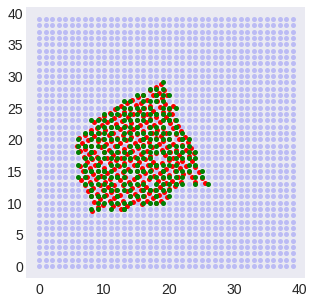

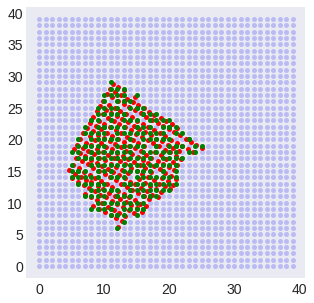

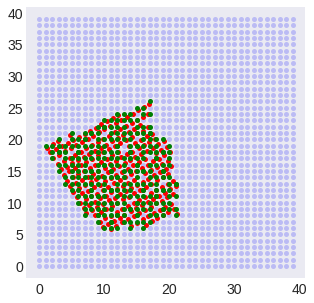

Found 14929 genes among all datasets
[[0.         0.86521739 0.81304348]
 [0.         0.         0.81304348]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14929 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 1.569262707606423

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.11938176051278426

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0010097023386588244

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.00018480670640030894



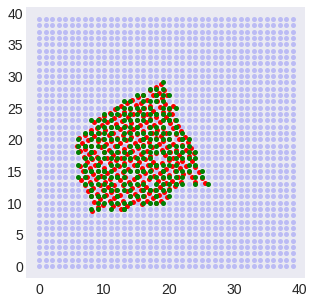

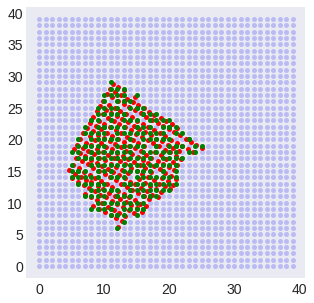

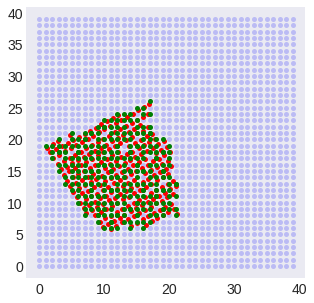

Found 14929 genes among all datasets
[[0.         0.85022026 0.83913043]
 [0.         0.         0.85217391]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14929 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.8522712283623852

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 2.4980018054066022e-14



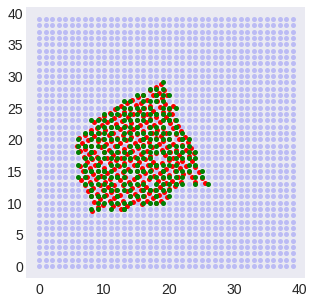

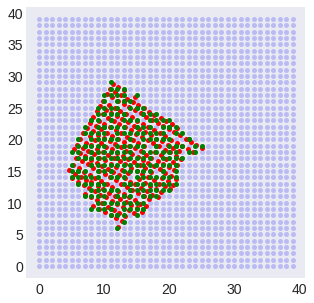

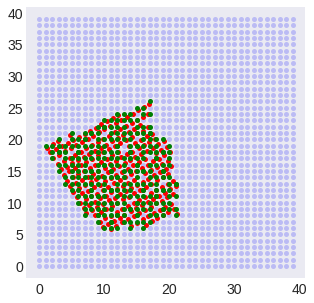

Found 14929 genes among all datasets
[[0.         0.84782609 0.76956522]
 [0.         0.         0.8173913 ]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14929 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.036931776693067256

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.2552327011668907

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0008240097045378869



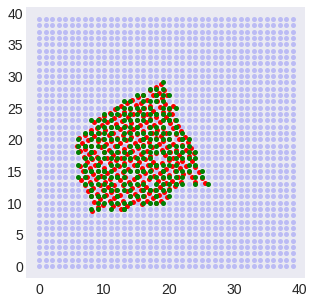

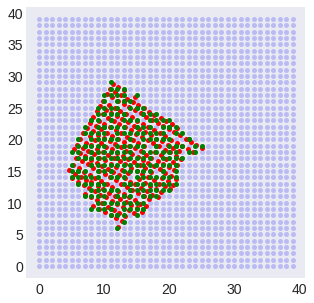

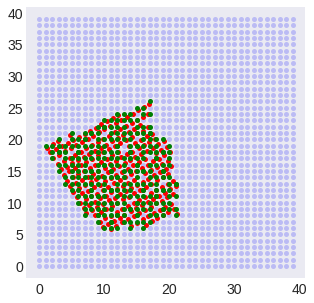

Found 14929 genes among all datasets
[[0.         0.86086957 0.79130435]
 [0.         0.         0.83478261]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14929 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.8336683202025309

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.4540278635899208

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.02216028936737985

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.009873113945158385

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0024854095868411807

Iteration: 5
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.002670102275260988

Iteration: 6
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0007837800865412858



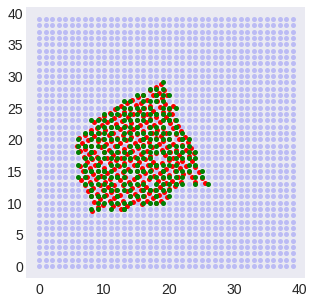

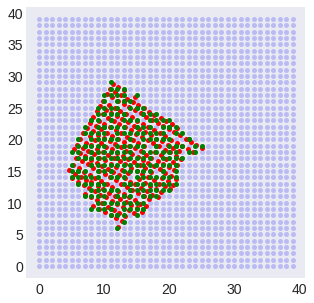

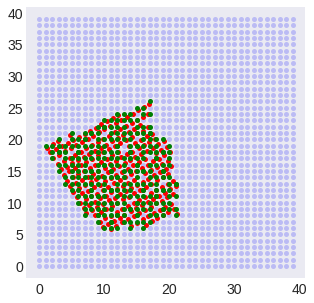

Found 14929 genes among all datasets
[[0.         0.86521739 0.77391304]
 [0.         0.         0.81304348]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14929 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 2.3767019740048028

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.7354365423304869

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0007868753170485743



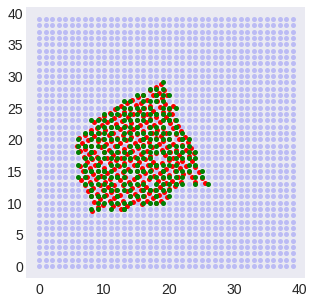

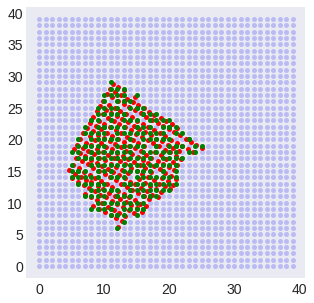

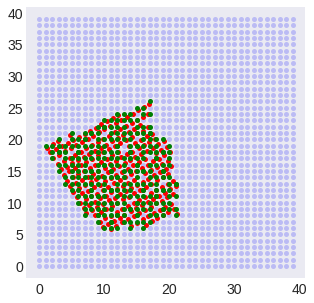

Found 14929 genes among all datasets
[[0.         0.82608696 0.80869565]
 [0.         0.         0.84782609]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14929 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 2.553652219539817

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.9671482803063527

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.013574255063530716

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0003080484937856287

IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII: 1


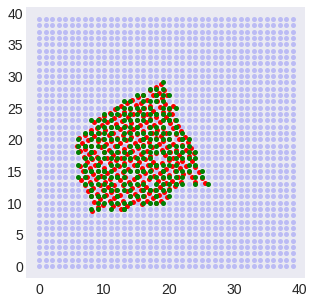

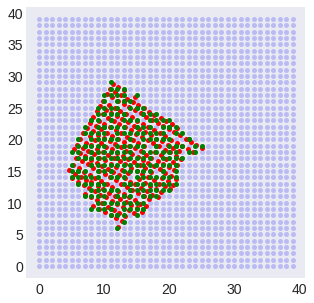

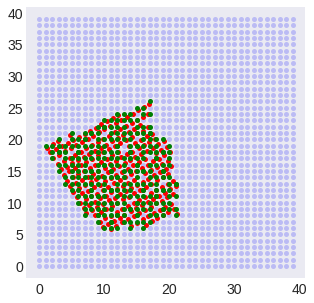

Found 14929 genes among all datasets
[[0.         0.85217391 0.78695652]
 [0.         0.         0.84782609]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14929 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 1.5617954367101643

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.12250821280506874

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.005933695563760999

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 9.365839515074192e-05



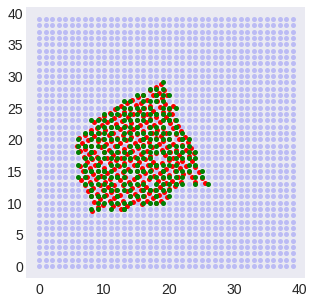

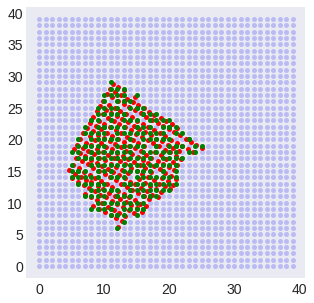

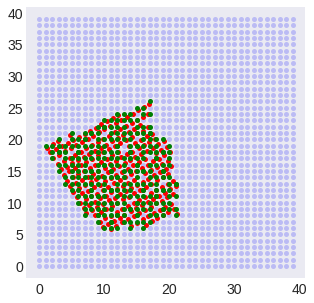

Found 14929 genes among all datasets
[[0.         0.83478261 0.79130435]
 [0.         0.         0.86956522]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14929 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.8522712283623852

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 2.4980018054066022e-14



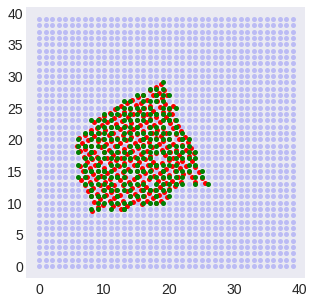

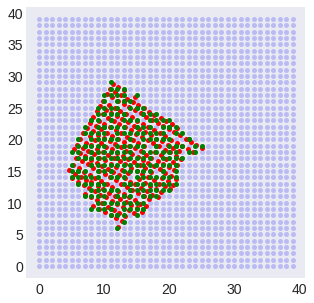

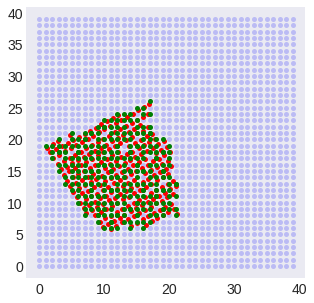

Found 14929 genes among all datasets
[[0.         0.77391304 0.70869565]
 [0.         0.         0.82378855]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14929 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.18020964118195382

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.21484941173352365

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0030763207293958428

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.003257204541622455

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.001401095451381451

Iteration: 5
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0006771715960572633



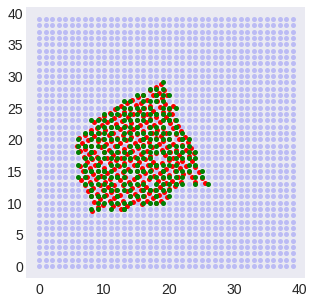

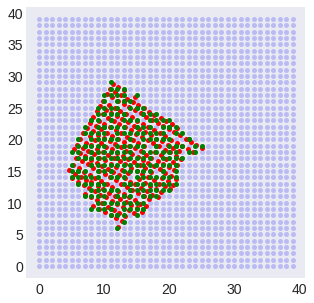

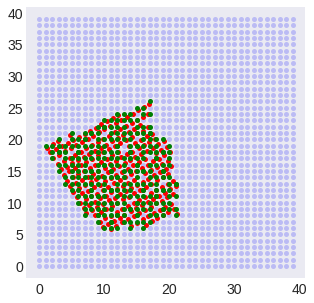

Found 14929 genes among all datasets
[[0.         0.88695652 0.81304348]
 [0.         0.         0.83043478]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14929 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.7766467880254934

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.41810666124957563

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.045842970049420284

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0032121082544022683

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.004544670004432094

Iteration: 5
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.00047271544638588514



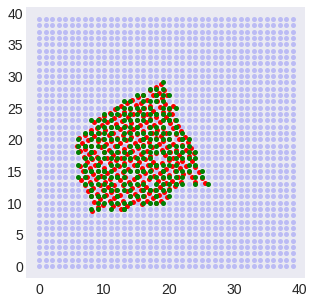

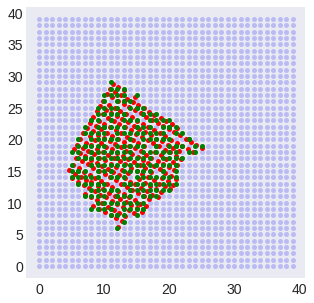

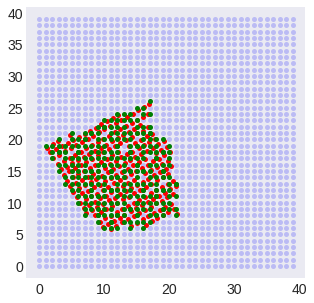

Found 14929 genes among all datasets
[[0.         0.81304348 0.79565217]
 [0.         0.         0.86086957]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14929 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 1.0695154448900688

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.7814292575941177

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.010681303540581943

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.008092234297398526

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.006447138050497181

Iteration: 5
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.005015231125570729

Iteration: 6
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.009002718625971184

Iteration: 7
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.011523912244236656

Iteration: 8
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.002629013685818471

Iteration: 9
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.004675446030626418



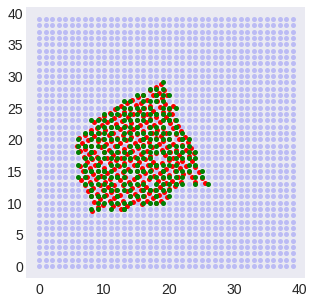

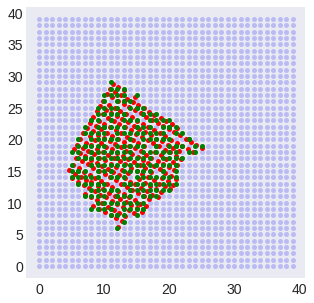

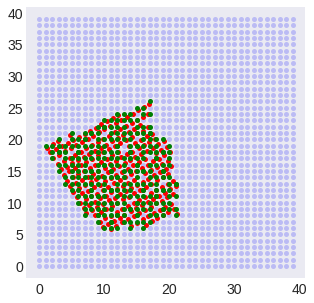

Found 14929 genes among all datasets
[[0.         0.84782609 0.7826087 ]
 [0.         0.         0.85217391]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14929 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 3.4775911126179313

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.982336620906878

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0025014511547793994

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0034174817047931683

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.003536387076977565

Iteration: 5
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.00503961923970575

Iteration: 6
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.003114538685018431

Iteration: 7
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.00030085593800111

IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII: 2


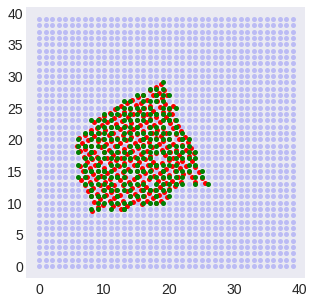

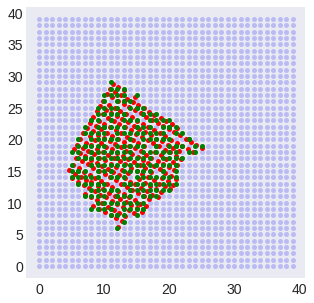

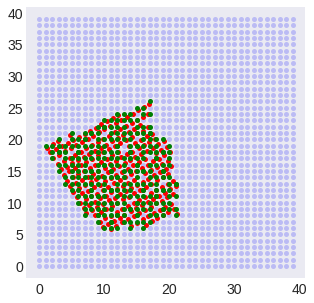

Found 14929 genes among all datasets
[[0.         0.87391304 0.79130435]
 [0.         0.         0.84347826]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14929 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 1.5789371312158043

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.1256304058533806

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.003999442588852542

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0005759196561794244



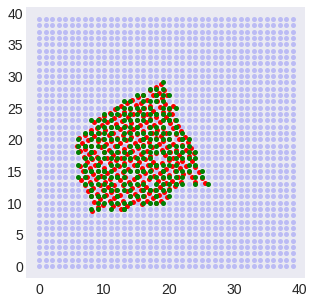

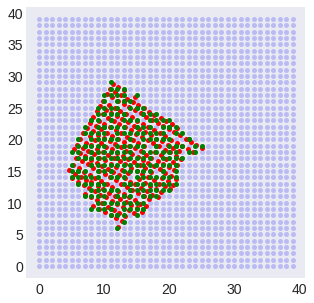

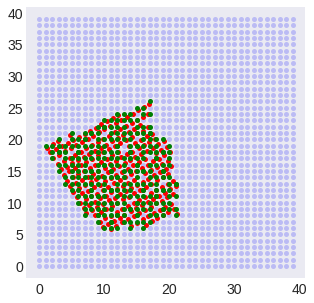

Found 14929 genes among all datasets
[[0.         0.80176211 0.76086957]
 [0.         0.         0.85217391]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14929 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.8522712283623852

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 2.4980018054066022e-14



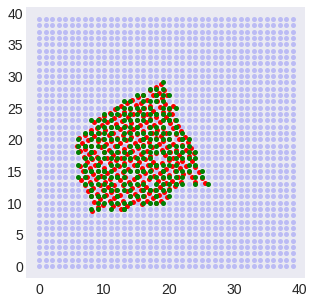

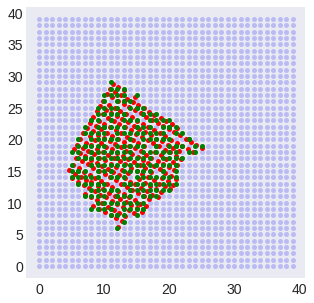

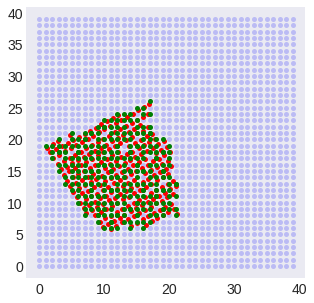

Found 14929 genes among all datasets
[[0.         0.87826087 0.77391304]
 [0.         0.         0.83913043]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14929 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.04748365254347636

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.250661735026423

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0004031703714708068



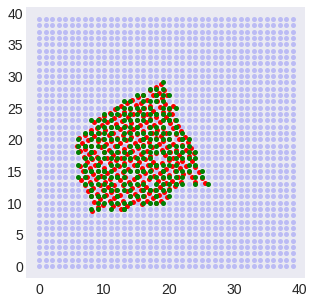

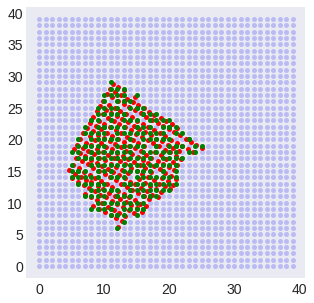

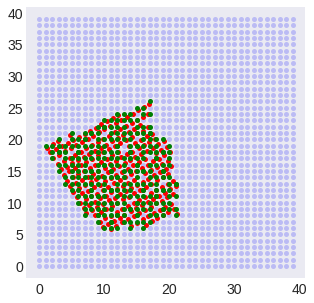

Found 14929 genes among all datasets
[[0.         0.83478261 0.75217391]
 [0.         0.         0.83913043]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14929 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.8022164108846398

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.39206774092605085

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0472961636823136

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0004235615459513564



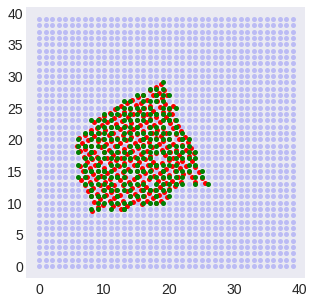

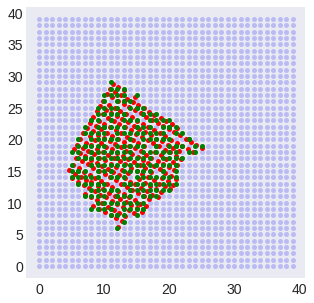

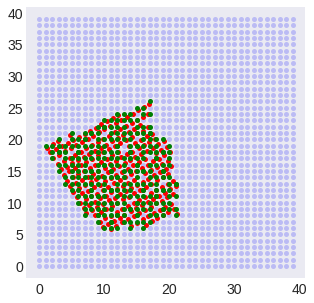

Found 14929 genes among all datasets
[[0.         0.85217391 0.78695652]
 [0.         0.         0.84782609]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14929 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 1.6620972938034206

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.7362332336126958

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0741718546740826

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.02938230368463124

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0009731095024065883



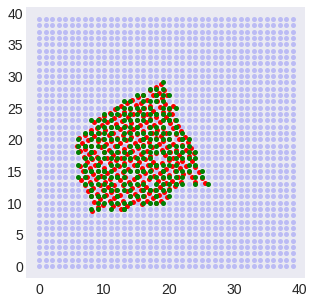

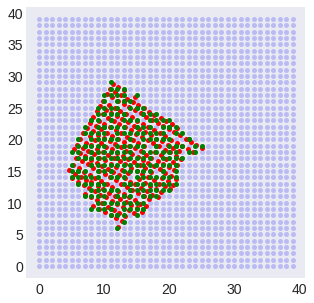

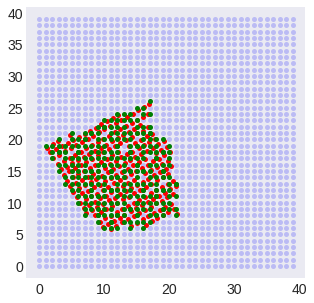

Found 14929 genes among all datasets
[[0.         0.87826087 0.80869565]
 [0.         0.         0.83478261]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14929 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 2.5078436616527147

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.9161243143782112

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.05197656756887947

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0027696415803746266

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.003531326551168057

Iteration: 5
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.00018133458503721833

IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII: 3


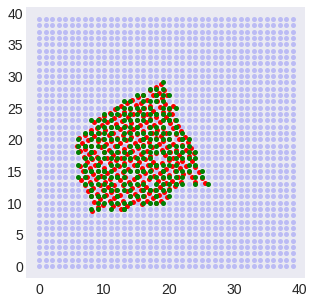

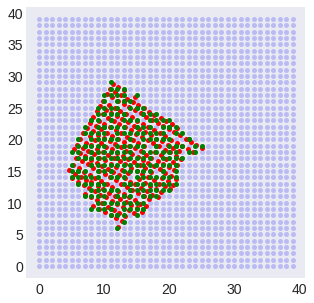

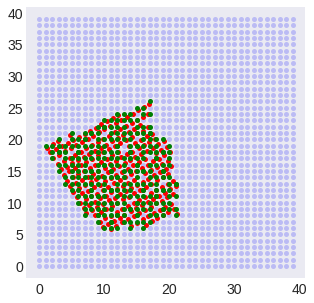

Found 14929 genes among all datasets
[[0.         0.86521739 0.79565217]
 [0.         0.         0.88695652]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14929 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 1.5630874963557417

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.12818517456155187

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.004751116164359415

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.002219222441079971

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.003277245270691065

Iteration: 5
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.004090431122163896

Iteration: 6
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.003971249758643491

Iteration: 7
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.00047445771865195496



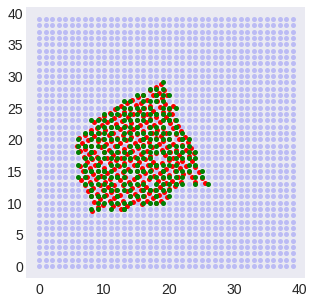

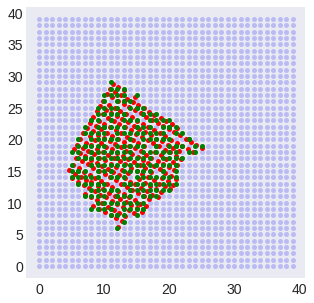

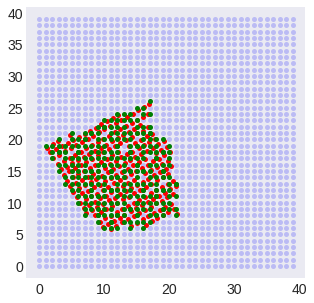

Found 14929 genes among all datasets
[[0.         0.83478261 0.77391304]
 [0.         0.         0.8173913 ]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14929 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.8522712283623852

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 2.4980018054066022e-14



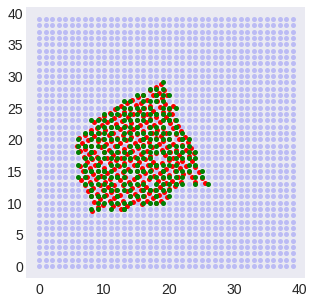

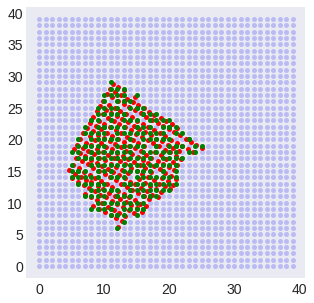

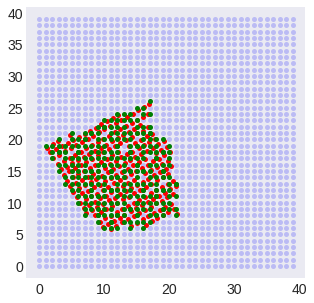

Found 14929 genes among all datasets
[[0.         0.79565217 0.80869565]
 [0.         0.         0.82608696]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 2)
Processing datasets (0, 1)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14929 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.5948573651364211

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.2596387632192513

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0002112398259704884



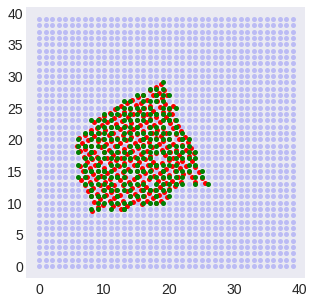

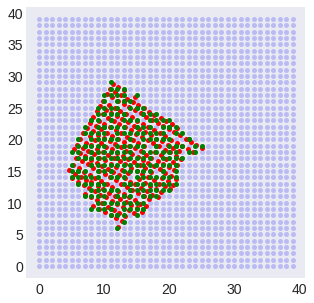

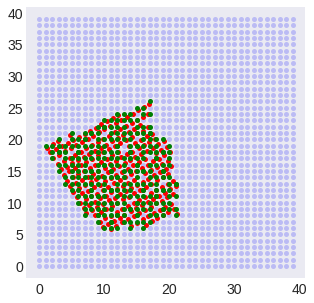

Found 14929 genes among all datasets
[[0.         0.83043478 0.77826087]
 [0.         0.         0.84782609]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14929 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.6028628557207029

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.37861950857390936

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.01870897811785427

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.006099114546091855

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.002068277472068697

Iteration: 5
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.003447712331535624

Iteration: 6
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0022437911057262283

Iteration: 7
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0052720644074071565

Iteration: 8
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.006390945779454288

Iteration: 9
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0043474412655036265



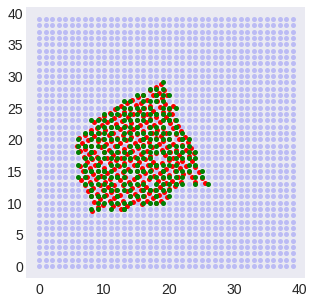

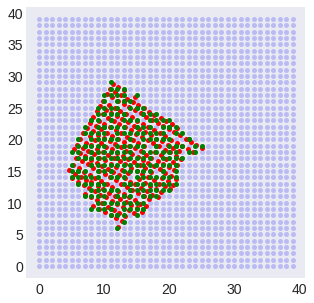

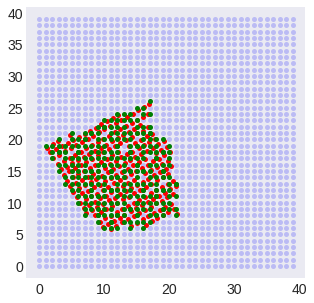

Found 14929 genes among all datasets
[[0.         0.85217391 0.76956522]
 [0.         0.         0.85652174]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14929 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 1.4350027845387556

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.6041586742514105

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0397250018191323

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.005244263559545659

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.004465762247161997

Iteration: 5
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.00022046015314713951



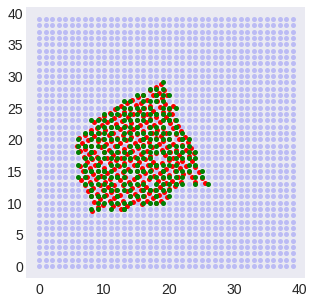

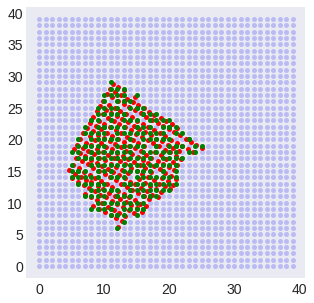

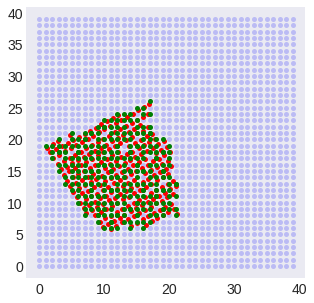

Found 14929 genes among all datasets
[[0.         0.83043478 0.79565217]
 [0.         0.         0.84782609]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14929 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 1.854673994743476

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 1.0668503271232583

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.014974374162895487

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.016593640776079832

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.021101825643178418

Iteration: 5
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.02236068484185394

Iteration: 6
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.01836253717174685

Iteration: 7
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.011602520931883631

Iteration: 8
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.006150517788943488

Iteration: 9
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.008106418413610483

IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII: 4


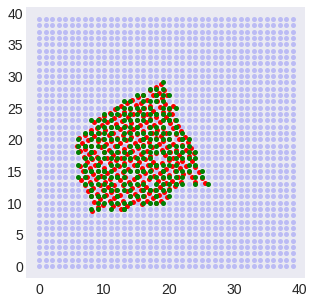

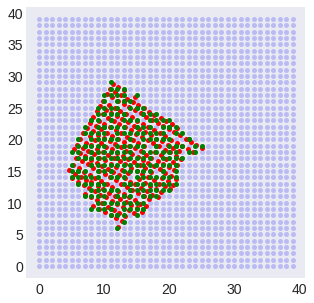

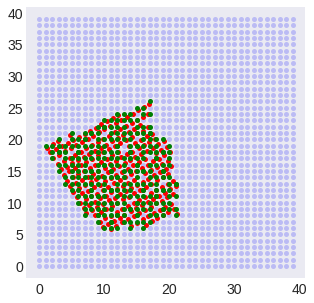

Found 14929 genes among all datasets
[[0.         0.85217391 0.76956522]
 [0.         0.         0.85652174]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14929 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 1.5647183727369793

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.12898316029828916

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0017109385440119418

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.00020007818459721882



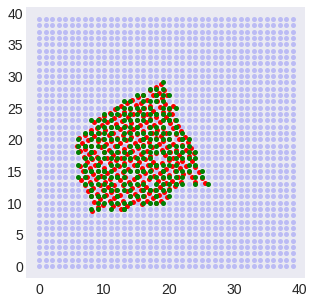

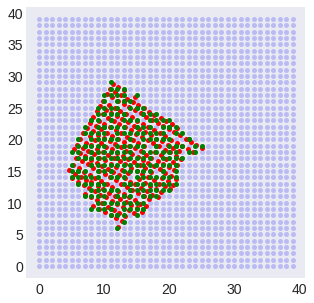

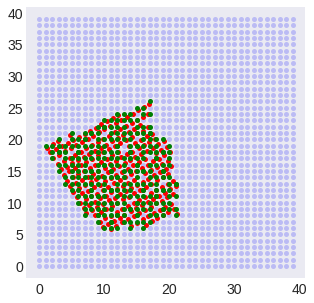

Found 14929 genes among all datasets
[[0.         0.85217391 0.78695652]
 [0.         0.         0.84782609]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14929 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.8522712283623852

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 2.4980018054066022e-14



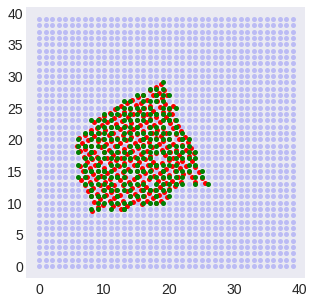

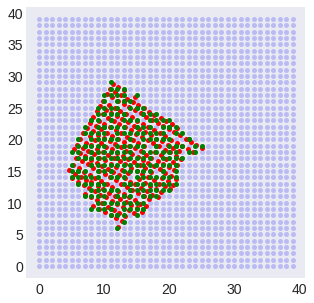

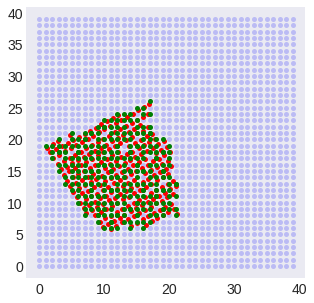

Found 14929 genes among all datasets
[[0.         0.84782609 0.82173913]
 [0.         0.         0.86521739]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14929 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.31896001822060216

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.24409062965364725

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0005964385820533824



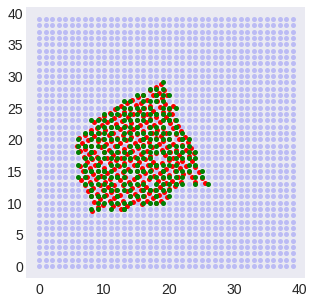

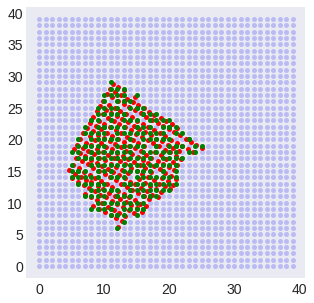

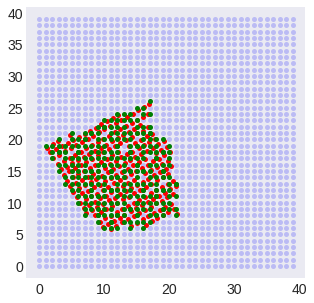

Found 14929 genes among all datasets
[[0.         0.86521739 0.82173913]
 [0.         0.         0.86956522]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14929 common genes.


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 1.2042881962032554

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.38076891649931743

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.024933662059481887

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0016357909776266721

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.00015186658098598205



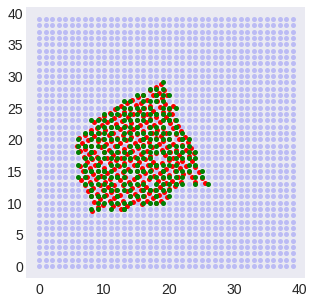

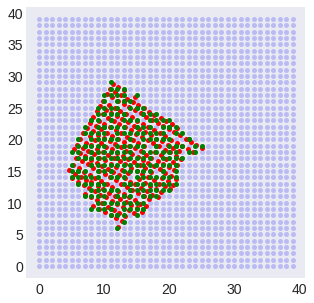

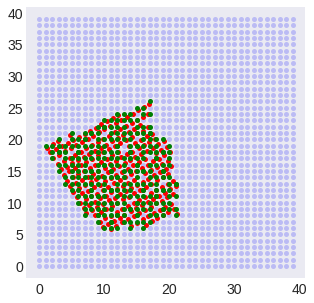

Found 14929 genes among all datasets
[[0.         0.87391304 0.82173913]
 [0.         0.         0.86086957]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14929 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 2.8631831330498634

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.6907667388945331

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0045863781887161

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0029510587955074996

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.009078321155548519

Iteration: 5
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.01383383485786327

Iteration: 6
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.002680823457593018

Iteration: 7
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.011881603901071625

Iteration: 8
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0019779666728441114

Iteration: 9
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.007152402397490043



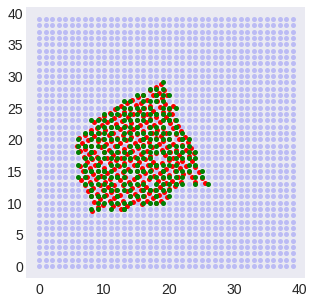

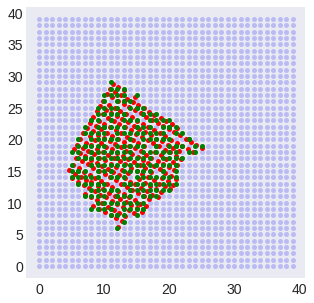

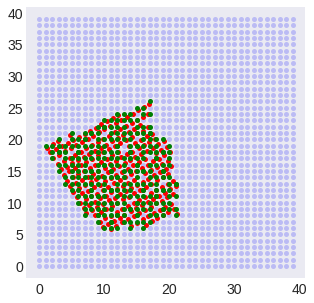

Found 14929 genes among all datasets
[[0.         0.84347826 0.74347826]
 [0.         0.         0.82608696]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Filtered all slices for common genes. There are 14929 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 3.3931479222160483

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.9624426805819457

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0037796864037416

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0027752773202953662

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.012313140478096951

Iteration: 5
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.007539640834083983

Iteration: 6
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0015450949978053075

Iteration: 7
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0009982110154238555



In [11]:
pseudocount = [0.1, 1, 2, 3, 4, 5]
paste_results = []
scanorama_results = []
for i in range(10):
    print("IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII: " + str(i))
    paste_1 = []
    scanorama_1 = []
    for p in pseudocount:
        s, p = sim(adata_layer_3, 0.1, p)
        paste_1.append(p)
        scanorama_1.append(s)
    paste_results.append(paste_1)
    scanorama_results.append(scanorama_1)

In [13]:
df = pd.DataFrame()
df['paste'] = np.mean(paste_results, axis = 0)
df['scanorama'] = np.mean(scanorama_results, axis = 0)
df.index = pseudocount
df

,paste,scanorama
0.1,105.355682,261.496676
1.0,134.440673,266.275034
2.0,137.041599,256.483218
3.0,136.373831,259.345888
4.0,134.477252,264.966646
5.0,134.266965,257.276174


In [14]:
# df.to_csv('../cachedResults/simData/center_kl/layer3_low_rank_initial.csv')